In [1]:
import pandas as pd
import os
import numpy.ma as ma

import numpy
from pyearth import Earth
from matplotlib import pyplot

np.random.seed(2017)

In [2]:
def df_from_csv(csv, index_col, data_folder='../data/interim'):
    print('Importing {}'.format(csv))
    return pd.read_csv(os.path.join(data_folder,csv), index_col=index_col)

df_profiles = df_from_csv('profiles.csv', index_col=[0, 1, 2])

Importing profiles.csv


C:\Users\z5189959\Desktop\nsw-2016-storm-impact\.venv\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Try using pyearth

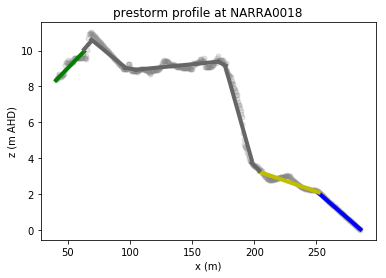

[   {   'slope': -0.06617795750241562,
        'type': 'land',
        'x_end': 63.0,
        'x_start': 40.5,
        'z_end': 9.943990321404,
        'z_mean': 9.20564731619437,
        'z_start': 8.348161899068224},
    {   'slope': -0.09424321140128608,
        'x_end': 69.0,
        'x_start': 63.0,
        'z_end': 10.532233612481347,
        'z_mean': 10.310033111599461,
        'z_start': 10.062895267627406},
    {   'slope': 0.07278057230588836,
        'x_end': 96.0,
        'x_start': 69.0,
        'z_end': 9.071344271845113,
        'z_mean': 9.942154478828064,
        'z_start': 10.600758995514095},
    {   'slope': 0.010222110457455531,
        'x_end': 105.0,
        'x_start': 96.0,
        'z_end': 8.940005362742282,
        'z_mean': 8.960960594412768,
        'z_start': 9.032076613769703},
    {   'slope': -0.006783434031405405,
        'x_end': 171.0,
        'x_start': 105.0,
        'z_end': 9.377956662680647,
        'z_mean': 9.12742372282666,
        'z_start':

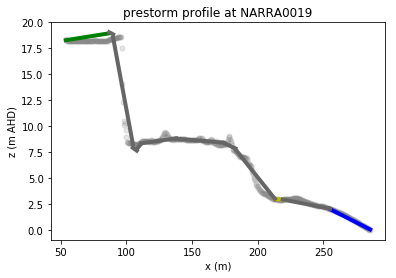

[   {   'slope': -0.006232531713848901,
        'type': 'land',
        'x_end': 87.0,
        'x_start': 54.0,
        'z_end': 18.907362973310256,
        'z_mean': 18.226859544431967,
        'z_start': 18.244707421270647},
    {   'slope': 0.10048504940215892,
        'x_end': 90.0,
        'x_start': 87.0,
        'z_end': 18.81114066206634,
        'z_mean': 18.95124513461371,
        'z_start': 19.011103385573893},
    {   'slope': 0.7867562476656698,
        'x_end': 105.0,
        'x_start': 90.0,
        'z_end': 8.264119331473214,
        'z_mean': 13.443236505259332,
        'z_start': 18.482680684877423},
    {   'slope': 0.138231538826561,
        'x_end': 108.0,
        'x_start': 105.0,
        'z_end': 7.625424767531349,
        'z_mean': 7.719382219664138,
        'z_start': 7.899377829775406},
    {   'slope': -0.24669278691155727,
        'x_end': 111.0,
        'x_start': 108.0,
        'z_end': 8.25183247996525,
        'z_mean': 8.037437899312298,
        'z_star

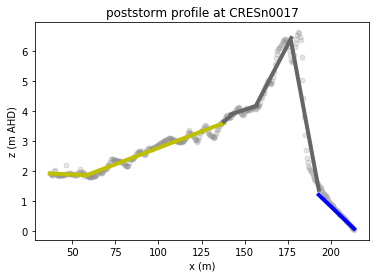

[   {   'slope': 0.0008328773436106309,
        'type': 'berm',
        'x_end': 58.0,
        'x_start': 37.0,
        'z_end': 1.8572595562110041,
        'z_mean': 1.8943805115420846,
        'z_start': 1.910394386927169},
    {   'slope': -0.021220543877635122,
        'type': 'berm',
        'x_end': 138.0,
        'x_start': 58.0,
        'z_end': 3.5977328867797485,
        'z_mean': 2.7247048500781106,
        'z_start': 1.8468598845719795},
    {   'slope': -0.06381773295732189,
        'x_end': 142.0,
        'x_start': 138.0,
        'z_end': 3.8359998018824712,
        'z_mean': 3.741723519647647,
        'z_start': 3.6479493664613014},
    {   'slope': -0.016157748520191067,
        'x_end': 157.0,
        'x_start': 142.0,
        'z_end': 4.169920934351783,
        'z_mean': 4.013083138991948,
        'z_start': 3.8843177342116757},
    {   'slope': -0.1322171985012303,
        'x_end': 177.0,
        'x_start': 157.0,
        'z_end': 6.427354838550462,
        'z_mean'

In [73]:
from scipy.signal import savgol_filter
import re
from scipy.stats import linregress
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_breakpoints(model, min_distance=20):
    # Get breakpoints
    breakpoints = []
    for line in model.summary().split('\n'):
        # Get unpruned lines
        if 'No' in line and 'None' not in line:
            # Get break points
            m = re.search("h\(x0-(\d*\.?\d+)\)", line)
            if m:
                breakpoints.append(float(m.groups()[0]))
            m = re.search("h\((\d*\.?\d+)-x0\)", line)
            if m:
                breakpoints.append(float(m.groups()[0]))
    return sorted(list(set(breakpoints)))
    
def get_segments(breakpoints, x_min, x_max):
    segments = []
    breakpoints = [x_min] + breakpoints + [x_max]

    for x1, x2 in zip(breakpoints, breakpoints[1:]):
        segments.append({
            'x_start': x1,
            'x_end': x2
        })
    return segments            

def get_segment_slopes(segments, x, z):
    for segment in segments:
        mask = ma.masked_where((segment['x_start'] < x) & (x < segment['x_end']),x ).mask
        segment['z_mean'] = np.mean(z[mask])
        segment['z_start'] = np.mean(z[mask][0])
        segment['z_end'] = np.mean(z[mask][-1])
        segment['slope'] = -linregress(x[mask], z[mask]).slope
    return segments
    
def classify_segments(segments, x,z):
    
    # Most seaward slope must be foreshore
    segments[-1]['type'] = 'foreshore'
    
    # Most landward slope must be land
    segments[0]['type'] = 'land'
    
    # Segments with really high slopes must be structures
    for seg in segments:
        if seg['slope'] > 2.0:
            seg['type'] = 'structure'
    
    # Segments with large change of slope and 
    # Segment with max slope should be dune face
#     dune_face_idx = [n for n, seg in enumerate(segments) if seg['slope']==max(x['slope'] for x in segments)][0]
#     segments[dune_face_idx]['type'] = 'dune_face'
    
    # Pick out berms 
    for seg in segments:
        if (-0.03 < seg['slope'] < 0.03  # berms should be relatively flat
            and 0 < seg['z_mean'] < 4  # berms should be located between 0-4 m AHD
            ):  # berms should be seaward of dune face
            seg['type'] = 'berm'
            
#     slope = None
#     for seg in reversed(segments):
#         if slope is None:
#             continue
#         elif slope - 0.03 < seg['slope'] < slope + 0.03:
#             seg['type'] = 'foreshore'
#         else:
#             break
    
    return segments

def get_piecewise_linear_model(x,z):
    #Fit an Earth model
    model = Earth(penalty=3,thresh=0.0005)
    model.fit(x,z)
    return model

def plot_profile_classification(site_id, profile_type):
    df_profile = df_profiles.query("site_id == '{}' and profile_type == '{}'".format(site_id, profile_type))
    x = np.array(df_profile.index.get_level_values('x').tolist())
    z = np.array(df_profile.z.tolist())    
    
    nan_mask = ma.masked_invalid(z).mask
    x = x[~nan_mask]
    z_unfiltered = z[~nan_mask]
    z = savgol_filter(z_unfiltered, 51, 3)
    
    model = get_piecewise_linear_model(x,z)
    breakpoints = get_breakpoints(model)
    segments = get_segments(breakpoints, x_min=x.min(), x_max=x.max())
    segments = get_segment_slopes(segments, x=x, z=z)
#     segments = merge_similar_segments(segments)
    segments = classify_segments(segments, x=x, z=z)
    
    pyplot.figure()
    pyplot.plot(x,z_unfiltered, color='0.5',marker='.', alpha=.2, ms=10,linestyle="None")

    # Plot different segments
    foreshore_segments = [x for x in segments if x.get('type') == 'foreshore']
    for seg in foreshore_segments:
        pyplot.plot([seg['x_start'], seg['x_end']],
                   [seg['z_start'], seg['z_end']],
                   linewidth=4, 
                    color='b')

    land_segments = [x for x in segments if x.get('type') == 'land']
    for seg in land_segments:
        pyplot.plot([seg['x_start'], seg['x_end']],
                   [seg['z_start'], seg['z_end']],
                   linewidth=4, 
                    color='g')

    berm_segments = [x for x in segments if x.get('type') == 'berm']
    for seg in berm_segments:
        pyplot.plot([seg['x_start'], seg['x_end']],
                   [seg['z_start'], seg['z_end']],
                    linewidth=4, 
                    color='y')

    dune_face_segments = [x for x in segments if x.get('type') == 'dune_face']
    for seg in dune_face_segments:
        pyplot.plot([seg['x_start'], seg['x_end']],
                   [seg['z_start'], seg['z_end']],
                    linewidth=4, 
                    color='r')
        
    structure_segments = [x for x in segments if x.get('type') == 'structure']
    for seg in structure_segments:
        pyplot.plot([seg['x_start'], seg['x_end']],
                   [seg['z_start'], seg['z_end']],
                    linewidth=4, 
                    color='m')
        
    unclassified_segments = [x for x in segments if x.get('type') is None]
    for seg in unclassified_segments:
        pyplot.plot([seg['x_start'], seg['x_end']],
                   [seg['z_start'], seg['z_end']],
                   linewidth=4, 
                    color='0.4')

    pyplot.xlabel('x (m)')
    pyplot.ylabel('z (m AHD)')
    pyplot.title('{} profile at {}'.format(profile_type, site_id))
    pyplot.show()

    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(segments)

plot_profile_classification('NARRA0018', 'prestorm')
plot_profile_classification('NARRA0019', 'prestorm')
plot_profile_classification('CRESn0017', 'poststorm')

## Try lmfit

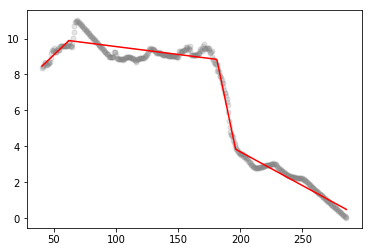

[[Model]]
    Model(piecewise_linear)
[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 79866
    # data points      = 491
    # variables        = 8
    chi-square         = 65.4379204
    reduced chi-square = 0.13548224
    Akaike info crit   = -973.533027
    Bayesian info crit = -939.961474
[[Variables]]
    x0:  62.1499306 (init = 40.5)
    x1:  181.207436 (init = 40.5)
    x2:  196.301872 (init = 40.5)
    b:   5.81709441 (init = 0)
    k1:  0.06544372 (init = 0)
    k2: -0.07421739 (init = 0)
    k3: -0.32199700 (init = 0)
    k4:  0.29325377 (init = 0)



In [26]:
from lmfit import Model, Parameters

def get_data():
    site_id='NARRA0018'
    profile_type='prestorm'
    df_profile = df_profiles.query("site_id == '{}' and profile_type == '{}'".format(site_id, profile_type))
    x = np.array(df_profile.index.get_level_values('x').tolist())
    z = np.array(df_profile.z.tolist())    

    nan_mask = ma.masked_invalid(z).mask
    x = x[~nan_mask]
    z = z[~nan_mask]
    return x,z

# def piecewise_linear(x, x0, x1, b, k1, k2, k3):
#     condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
#     funclist = [lambda x: k1*x + b, lambda x: k1*x + b + k2*(x-x0), lambda x: k1*x + b + k2*(x-x0) + k3*(x - x1)]
#     return np.piecewise(x, condlist, funclist)

# x,z = get_data()

# fmodel = Model(piecewise_linear)
# params = Parameters()
# params.add('x0', value=0, vary=True, min=min(x), max=max(x))
# params.add('x1', value=0, vary=True, min=min(x), max=max(x))
# params.add('b', value=0, vary=True)
# params.add('k1', value=0, vary=True, min=-0.01, max=0.01)
# params.add('k2', value=0, vary=True, min=-0.1, max=-0.5)
# params.add('k3', value=0, vary=True, min=0.1, max=0.5)

def piecewise_linear(x, x0, x1, x2, b, k1, k2, k3,k4):
    condlist = [x < x0, (x >= x0) & (x < x1), (x >= x1) & (x < x2), x >= x2]
    funclist = [lambda x: k1*x + b, lambda x: k1*x + b + k2*(x-x0), lambda x: k1*x + b + k2*(x-x0) + k3*(x - x1), lambda x: k1*x + b + k2*(x-x0) + k3*(x - x1) +k4*(x-x2)]
    return np.piecewise(x, condlist, funclist)

x,z = get_data()

fmodel = Model(piecewise_linear)
params = Parameters()
params.add('x0', value=0, vary=True, min=min(x), max=max(x))
params.add('x1', value=0, vary=True, min=min(x), max=max(x))
params.add('x2', value=0, vary=True, min=min(x), max=max(x))
params.add('b', value=0, vary=True)
params.add('k1', value=0, vary=True, min=-0.5, max=0.5)
params.add('k2', value=0, vary=True, min=-0.5, max=0.5)
params.add('k3', value=0, vary=True, min=-0.5, max=0.5)
params.add('k4', value=0, vary=True, min=-0.5, max=0.5)


result = fmodel.fit(z, params, x=x,method='ampgo')


pyplot.figure()
pyplot.plot(x,z, color='0.5',marker='.', alpha=.2, ms=10,linestyle="None")
pyplot.plot(x,result.best_fit, color='r')
pyplot.show()
print(result.fit_report())

## Try spline

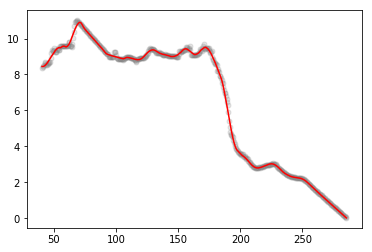

In [65]:
from scipy.signal import savgol_filter

def get_data():
    site_id='NARRA0018'
    profile_type='prestorm'
    df_profile = df_profiles.query("site_id == '{}' and profile_type == '{}'".format(site_id, profile_type))
    x = np.array(df_profile.index.get_level_values('x').tolist())
    z = np.array(df_profile.z.tolist())    

    nan_mask = ma.masked_invalid(z).mask
    x = x[~nan_mask]
    z = z[~nan_mask]
    return x,z

x,z = get_data()

z_filtered = savgol_filter(z, 31, 3)


pyplot.figure()
pyplot.plot(x,z, color='0.5',marker='.', alpha=.2, ms=10,linestyle="None")
pyplot.plot(x,z_filtered, color='r')
pyplot.show()
